# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [317]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib
from scipy.stats import skew
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# import xgboost as xgb
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


## Load custom module
import functions as fn
importlib.reload(functions)


# import is_string_dtype, is_numeric_dtype

# magic word for producing visualizations in notebook
%matplotlib inline

## Table of Contents:
* [Get to Know the Data](#gettoknowthedata)
    * [Missing values](#missingvalues)
    * [Data cleaning](#dataclean)
    * [Feature engineering](#featureengineering)
* [Customer Segmentation Report](#customersegm)
    * [Principal Components Analysis](#pca)
    * [K-Means](#kmeans)
    * [Cluster Analysis](#clusteranalysis)

## Part 0: Get to Know the Data <a class="anchor" id="gettoknowthedata"></a>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [268]:
# # load in the data
# azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [269]:
# # load in the data
# azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
# customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [270]:
## pickle data to speed up loading times

# pickle.dump(azdias, open('data/azdias.pckl','wb'))
# pickle.dump(customers, open('data/customers.pckl','wb'))
azdias = pickle.load(open('data/azdias.pckl','rb'))
customers = pickle.load(open('data/customers.pckl','rb'))

First, we take a look at the general structure of the datasets, the column types and missing values

In [271]:
### azdias dataset

print("The general German information has {} rows and {} columns".format(azdias.shape[0], azdias.shape[1]))
azdias.head()




The general German information has 891221 rows and 366 columns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [272]:
azdias.describe(include = 'all')

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000


In [273]:
### azdias dataset

print("The customer information has {} rows and {} columns".format(customers.shape[0], customers.shape[1]))
customers.head()



The customer information has 191652 rows and 369 columns


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [274]:
customers.describe(include='all')

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652,191652,191652.000000,191652.000000,191652.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,COSMETIC_AND_FOOD,MULTI_BUYER,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100860,132238,NaN,NaN,NaN
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,3.168868,4.152716,8.646371,3.723133,2.576806,NaN,NaN,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.233516,1.974375,1.154001,2.095540,1.168486,NaN,NaN,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,NaN,NaN,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,1.000000,2.000000,9.000000,2.000000,1.000000,NaN,NaN,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,3.000000,5.000000,9.000000,3.000000,3.000000,NaN,NaN,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,4.000000,6.000000,9.000000,5.000000,3.000000,NaN,NaN,0.000000,2.000000,4.000000


### Missing Values <a class="anchor" id="missingvalues"></a>

At a first glance there are several columns with empty values. In the following section we investigate this further in order to reduce the dataset by dropping columns filled with empty values.

In [275]:
azdias_null_count = azdias.isnull().sum() ## total missing values
azdias_null_share = pd.DataFrame({'share':azdias_null_count/azdias.shape[0]}).sort_values(by='share',ascending=False).reset_index()

In [276]:
print("98% of columns have {}% of null values".format(round(float(azdias_null_share['share'].quantile(0.98))*100,2)))


98% of columns have 28.85% of null values


In [277]:
drop_columns = list(azdias_null_share[azdias_null_share['share']>0.2885]['index'])

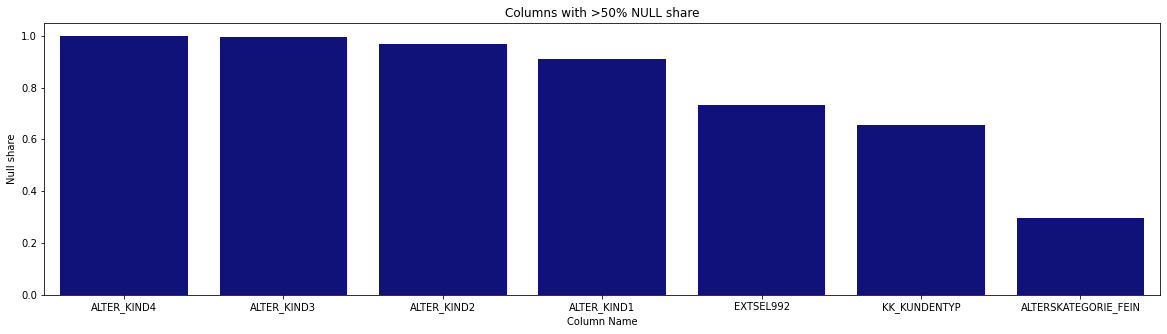

In [278]:
plt.rcParams["figure.figsize"] = (20,5)
sns.barplot(data = azdias_null_share[azdias_null_share['index'].isin(drop_columns)],
x = 'index',
y = 'share',
color = 'darkblue'
)
plt.xlabel('Column Name')
plt.ylabel('Null share')
plt.title('Columns with >50% NULL share');



In the file `DIAS Attributes - Values 2017.xlsx` there are levels described for each column which correspond to "missing" information (*e.g.*, unknown). We consider, however, that an unknown value is not necessary equivalent to NULL since the abscence of information in certain feature can actually be of benefit for fitting. For this reason, only true empty values are considered for dropping columns.

In the following, we explore eliminating rows with missing values as eliminating incomplete entries can also contribute to improve our fit.

In [279]:
azdias_nrows_count = azdias.isnull().sum(axis=1)
azdias_nrows_share = pd.DataFrame({'share':azdias_nrows_count/azdias.shape[1]}).sort_values(by='share',ascending=False)


In [280]:
print(azdias_nrows_share.describe())
print("95% of rows have less than {}% empty columns".format(round(azdias_nrows_share['share'].quantile(0.95)*100,2)))


               share
count  891221.000000
mean        0.102680
std         0.205711
min         0.000000
25%         0.013661
50%         0.016393
75%         0.043716
max         0.707650
95% of rows have less than 69.13% empty columns


In [281]:
drop_rows = azdias_nrows_share[azdias_nrows_share['share']>= 0.69].index
print("Dropping all rows with more than 69.13% of empty columns will result on a loss of {}% of the rows".
      format(round(len(drop_rows)*100/azdias.shape[0],2)))

Dropping all rows with more than 69.13% of empty columns will result on a loss of 5.12% of the rows


### Data cleaning <a class="anchor" id="dataclean"></a>

In addition to eliminating empty values, we also address the following:
* Removing redundant columns or with many unique values
* Parsing columns to their correct data format according their content (*e.g.*, dates as dates, numbers as float or int, etc.).

In [282]:
cat_columns = azdias.select_dtypes(['object']).columns
print(azdias[cat_columns].describe())        

       CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
count          792242          792242          792242   
unique             45              19              43   
top                6B               8              51   
freq            56672           78023           77576   

       D19_LETZTER_KAUF_BRANCHE        EINGEFUEGT_AM OST_WEST_KZ  
count                    634108               798073      798073  
unique                       35                 5162           2  
top               D19_UNBEKANNT  1992-02-10 00:00:00           W  
freq                     195338               383738      629528  


In [283]:
for c in cat_columns:
    print('{} has {} unique values with the following content:'.format(c, azdias[c].nunique()))
    print(azdias[c].unique)

CAMEO_DEU_2015 has 45 unique values with the following content:
<bound method Series.unique of 0         NaN
1          8A
2          4C
3          2A
4          6B
         ... 
891216     7A
891217     9D
891218     4C
891219     9D
891220     6B
Name: CAMEO_DEU_2015, Length: 891221, dtype: object>
CAMEO_DEUG_2015 has 19 unique values with the following content:
<bound method Series.unique of 0         NaN
1           8
2           4
3           2
4           6
         ... 
891216      7
891217      9
891218      4
891219      9
891220      6
Name: CAMEO_DEUG_2015, Length: 891221, dtype: object>
CAMEO_INTL_2015 has 43 unique values with the following content:
<bound method Series.unique of 0         NaN
1          51
2          24
3          12
4          43
         ... 
891216     41
891217     51
891218     24
891219     51
891220     43
Name: CAMEO_INTL_2015, Length: 891221, dtype: object>
D19_LETZTER_KAUF_BRANCHE has 35 unique values with the following content:
<bound method Se

Even though `CAMEO_DEU_2015` has many unique values, the information that it provides is important. `CAMEO_DEUG_2015` and `CAMEO_INTL_2015`, however, are somewhat redundant as the same information can be found in `CAMEO_DEU_2015` there fore they can be dropped. Additionally, `D19_LETZTER_KAUF_BRANCHE` has too many unique values and can also be dropped.

In [284]:
drop_columns = drop_columns + ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'D19_LETZTER_KAUF_BRANCHE', 'LNR']
drop_columns

['ALTER_KIND4',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'ALTERSKATEGORIE_FEIN',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'LNR']

In [285]:
az_clean = fn.clean_data(df = azdias, drop_rows= drop_rows, drop_cols= drop_columns)

In [286]:
# Print new shape and datatypes
print("Old shape: {}".format(azdias.shape))
print("New shape: {} \n".format(az_clean.shape))
print("Datatypes:")
print(az_clean.dtypes.value_counts())

Old shape: (891221, 366)
New shape: (845625, 355) 

Datatypes:
float64    262
int64       92
object       1
dtype: int64


In the same way the customers dataset needs to be cleaned. There are, however additional columns which are not found in the German data. 

In [287]:
## The customers data set
diff_cols = list(set(customers.columns) - set(azdias.columns))

In [288]:
customers_nrows_count = customers.isnull().sum(axis=1)
customers_nrows_share = pd.DataFrame({'share':customers_nrows_count/customers.shape[1]}).sort_values(by='share',ascending=False)
customers_drop_rows = customers_nrows_share[customers_nrows_share['share']>= 0.69].index


In [289]:
customers_clean = fn.clean_data(df = customers, drop_rows = customers_drop_rows, drop_cols = drop_columns + diff_cols)

In [290]:
# Print new shape and datatypes
print("Old shape: {}".format(customers.shape))
print("New shape: {} \n".format(customers_clean.shape))
print("Datatypes:")
print(customers_clean.dtypes.value_counts())

Old shape: (191652, 369)
New shape: (191648, 355) 

Datatypes:
float64    262
int64       92
object       1
dtype: int64


### Feature Engineering <a class="anchor" id="featureengineering"></a>

In addition to cleaning the data set, some feature engineering work needs to be done. In this section we address imputing empty values, and transforming/standarizing features depending on the column type.

In [291]:
## Imputing pipe line for binary variables
bin_cols = fn.find_binary_cols(az_clean)
print("Binary features", bin_cols)

bin_pipe = Pipeline([('bin_impute'
                             , SimpleImputer(missing_values=np.nan
                                             , strategy='most_frequent'
                                            )
                            )])

Binary features ['DSL_FLAG', 'GREEN_AVANTGARDE', 'HH_DELTA_FLAG', 'KONSUMZELLE', 'OST_WEST_KZ', 'SOHO_KZ', 'UNGLEICHENN_FLAG', 'ANREDE_KZ']


In [292]:
## Imputing and encoding for categorical variables

cat_cols = fn.find_cat_cols(az_clean)
print("Categorical features", cat_cols)

cat_pipe = Pipeline([
    ('cat_impute', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

Categorical features ['CAMEO_DEU_2015']


In [293]:
## Imputing for remaining numerical variables

num_cols = list(set(az_clean.columns) - set(bin_cols) - set(cat_cols))
print("Numerical features (first 10 on the list)", num_cols[1:10])

num_pipe = Pipeline([
    ('num_impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('num_scale', StandardScaler())
])


Numerical features (first 10 on the list) ['KBA05_SEG6', 'KBA13_BMW', 'AKT_DAT_KL', 'KBA13_KMH_210', 'ZABEOTYP', 'KBA05_KRSHERST2', 'KBA05_VORB0', 'KBA13_CCM_3001', 'CJT_TYP_5']


In [294]:
### Combining transformers

column_transformer = ColumnTransformer(
    transformers = [
        ('bin', bin_pipe, bin_cols),
        ('cat', cat_pipe, cat_cols),
        ('num', num_pipe, num_cols)
    ]
)

az_trans = column_transformer.fit_transform(az_clean)

In [295]:
## Transform az_trans to a data frame (recover column names from transformator)

onehot_names = list(column_transformer.transformers_[1][1].named_steps['onehot'].get_feature_names(cat_cols))
col_names = bin_cols + onehot_names + num_cols
az_df = pd.DataFrame(az_trans, columns = [col_names])

In [296]:
## Check data types in transformed data set
az_df.dtypes.value_counts()

float64    399
dtype: int64

In [297]:
## Pickle transformed dataset 

# pickle.dump(az_df, open('az_df.pckl','wb'))

## Part 1: Customer Segmentation Report <a class="anchor" id="customersegm"></a>

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Principal Component Analysis <a class="anchor" id="pca"></a>

In [298]:
# az_df = pickle.load(open('data/az_df.pckl','rb'))

In [299]:
az_df.shape[1]

399

The transformed German dataset has 399 different features even after the data cleaning process. In order to reduce the number of features an approach such as Principal Component Analysis can be applied.

In [300]:
## Fit the PCA model

az_pca = PCA().fit(az_df)

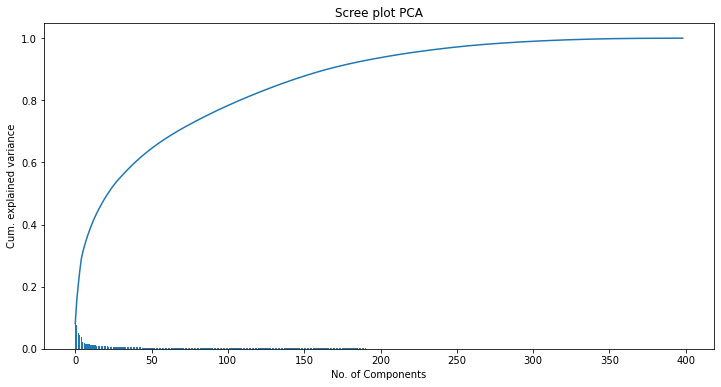

In [301]:
fn.scree_plot(az_pca)

From this plot we observe that around 200 components explain more than 90% of the variance, which means we can reduce our dataset to almost half of the features without loosing much predictive power.

In [302]:
pca_red = PCA(n_components=200).fit(az_df)
az_red = pd.DataFrame(pca_red.transform(az_df))

### K-Means <a class="anchor" id="kmeans"></a>

We know we can reduce the features in the data for clustering, however, as we make use of a K-Means algorithm for clustering, we still need to determine the no. of clusters required. This can be done, *e.g.* by using the elbow method.

In [303]:
## Loop over a range of possible cluster values

sum_squared_d = []

for i in np.arange(2,41):
    k = KMeans(n_clusters = i, init = "k-means++")
    k.fit(az_red.sample(10000))
    sum_squared_d.append(k.inertia_)

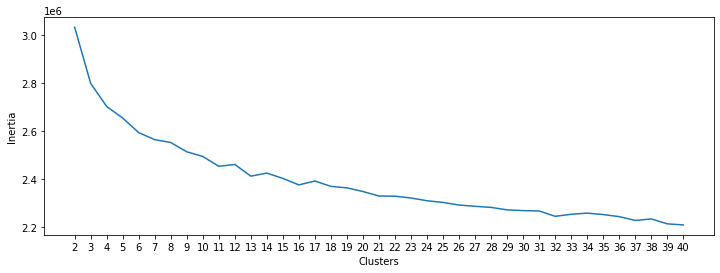

In [304]:
## Plot sum_squares vs. no. of clusters

plt.figure(figsize = (12,4))
plt.plot(np.arange(2,41), sum_squared_d, '-')
plt.xticks(np.arange(2,41))
plt.xlabel("Clusters")
plt.ylabel("Inertia");

Although not entirely clear from the plot, we observe that the inertia reduces drastically in the range of 2 to 5 clusters. This reduction shows the same trend up to 11 clusters, where the next inflexion can be found. From this point on the slope becomes less steep which indicates no further (impactful) gains can be achieved by increasing the number of clusters to more than 11. 

### Cluster analysis <a class="anchor" id="clusteranalysis"></a>

Once we obtained to which level we can reduce the features of the dataset (*i.e.*, PCA) and the optimal number of clusters to fit (*i.e.*, elbow method for K-Means) then we can proceed to cluster the data to proceed with our analysis. Briefly explained, the approach we use is to fit the reduced German population into K-Means and use the same model to predict the clustering of the customers dataset. Once obtained, the clusters per sample can be compared to determine which group of customers are over- or underrepresented with respect to the general German population.

In [305]:
## Setup pipeline to reduce and cluster data

n_components = 200
n_clusters = 11

cluster_pipe = Pipeline([
    ('transform', column_transformer)
    ,('reduction', PCA(n_components= n_components))
    ,('clustering', KMeans(n_clusters = n_clusters, init = 'k-means++'))
])
cluster_pipe.fit(az_clean)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('bin',
                                                  Pipeline(steps=[('bin_impute',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['DSL_FLAG',
                                                   'GREEN_AVANTGARDE',
                                                   'HH_DELTA_FLAG',
                                                   'KONSUMZELLE', 'OST_WEST_KZ',
                                                   'SOHO_KZ',
                                                   'UNGLEICHENN_FLAG',
                                                   'ANREDE_KZ']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequ

In [306]:
## Create clustered dataframes

az_clust = pd.DataFrame(cluster_pipe.predict(az_clean), columns = ["Cluster"])
customers_clust = pd.DataFrame(cluster_pipe.predict(customers_clean), columns = ["Cluster"])

# pickle.dump(az_clust, open('az_clust.pckl','wb'))

# pickle.dump(customers_clust, open('customers_clust.pckl','wb'))

In [307]:
## Join clustered datasets into one dataframe

clusters = pd.DataFrame({'Germany':az_clust.value_counts().sort_index()
              , 'Customers':customers_clust.value_counts().sort_index()}).reset_index()
clusters['Cluster'] += 1
clusters['Germany_share'] = clusters['Germany']/clusters['Germany'].sum()
clusters['Customers_share'] = clusters['Customers']/clusters['Customers'].sum()
clusters['Delta'] = clusters['Customers_share'] - clusters['Germany_share']


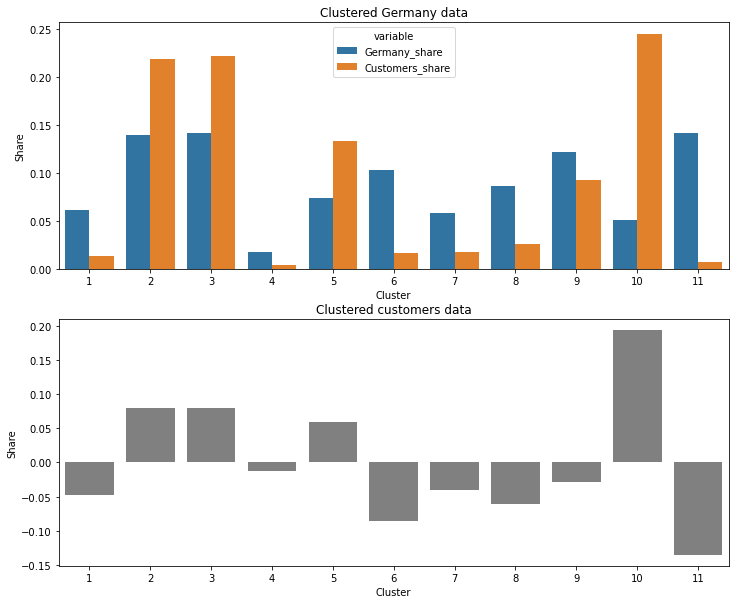

In [308]:
# # Plot clusters 

plt.rcParams["figure.figsize"] = (12,10)

plt.subplot(2,1,1)

sns.barplot(data = clusters.drop(['Germany', 'Customers', 'Delta'], axis = 1).melt(id_vars = ['Cluster']),
x = 'Cluster',
y = 'value',
hue = 'variable'
)
plt.xlabel('Cluster')
plt.ylabel('Share')
plt.title('Clustered Germany data');

plt.subplot(2,1,2)

sns.barplot(data = clusters,
x = 'Cluster',
y = 'Delta',
color = 'grey'#'darkred'
)
plt.xlabel('Cluster')
plt.ylabel('Share')
plt.title('Clustered customers data');

From these graphs we make the following observations:
* The German data is somewhat balanced across clusters with the exception of clusters 2 and 5. The Customers data, in contrast, is highly concentraded in few clusters (2, 3, and 9).
* Precisely clusters 2, 3, 9 are the most overrepresented clusters in comparison to the German data, as seen by the positive difference in shares. Clusters 8, 6, and 4, on the other hand, are underepresented with respect to the German data, as the difference in shares is negative.

The recommendation to the marketing campaing, thus, is to focus on the customers in clusters 2, 3, and 9 as they stand out from the general population whereas clusters 8,6 and 4 are quite underepresented and should not be part of the focus group.

In [319]:
## Extract the values of cluster centers for all clusters
cluster_centers = fn.get_cluster_centers(cluster_pipe, num_cols,col_names)

In [330]:
## Separate focus vs non focus clusters selected based on our analysis

focus_clusters = cluster_centers.iloc[[2,3,9]].T
nfocus_cluster = cluster_centers.iloc[[4,6,8]].T

In [351]:
focus_clusters[focus_clusters.std(axis = 1) >= 5]

,2,3,9
KBA05_SEG6,0.135763,8.953258,0.034807
GEBURTSJAHR,1046.153851,733.150370,9.602039
ANZ_HAUSHALTE_AKTIV,2.274254,25.843414,5.687133
ANZ_STATISTISCHE_HAUSHALTE,2.234783,26.543283,4.719207
KBA13_ANZAHL_PKW,721.835221,536.227356,588.088830
GEMEINDETYP,31.743889,20.381408,22.457866


## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')